# CSE 519 HW3
## Tyler Estro (), Noushin Salek Faramarzi (), Tim Zhang (110746199)

# Initialization

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import re
import math
import sklearn
from sklearn import linear_model
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics.pairwise import euclidean_distances
from scipy.stats import zscore

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (20,20)

In [2]:
# Load dataset as data matrix X
X = pd.read_csv(open("properties_2017.csv", "rb"))

/Users/heatherfrantz/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Scoring Function

## Feature Selection and Imputation

One of the most important features of a house is size.  For this reason, we have selected a curated feature set involving mainly this attribute.  While size is an important attribute, the layout of a house is also very important.  Thus we also included properties of layout, such as the counts of bedrooms, bathrooms, and the size of garages.  Additionally, age seems to be an important aspect of a home so we include this feature as well.

We will consider the following features for our scoring function:
* 'bathroomcnt' 
* 'bedroomcnt'
* 'calculatedfinishedsquarefeet'
* 'taxamount'
* 'yearbuilt'
* 'basementsqft'
* 'garagetotalsqft' 
* 'buildingqualitytypeid'

In [3]:
scoring_features = X[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'taxamount']]

We employ a custom imputation scheme.

* For each of the features in scoring_features we will use median imputation, since for of these domains the median seems to be a reasonable and robust method.

* For both basementsqft and garagetotalsqft, it seems a more reasonable assumption that if there is no record of these fields the property may simply not have a basement or a garage.  Thus we impute with a value of 0.

* Finally, ID based features should be imputed using the mode of the sample.  It seems reasonable that the most frequent ID in the dataset would continue to be most frequent.

In [4]:
imputed_scoring_features = scoring_features.fillna(scoring_features.median())
imputed_yearbuilt = X['yearbuilt'].fillna(X['yearbuilt'].median())
imputed_scoring_features['basementsqft'] = X['basementsqft'].fillna(0)
imputed_scoring_features['garagetotalsqft'] = X['garagetotalsqft'].fillna(0)
imputed_scoring_features['buildingqualitytypeid'] = X['buildingqualitytypeid'].fillna(X['buildingqualitytypeid'].mode()[0])

We create a custom 'age' feature by subtracting the current year by yearbuilt.

In [5]:
imputed_scoring_features['age'] = 2017 - imputed_yearbuilt

Next let's save our feature set for later analysis.

In [6]:
original_scoring_features = imputed_scoring_features.copy(deep=True)

## Exploratory Analysis and Cleaning

Next it seems prudent to plot the distributions of our features.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x104f7be90>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x110dfda50>]], dtype=object)

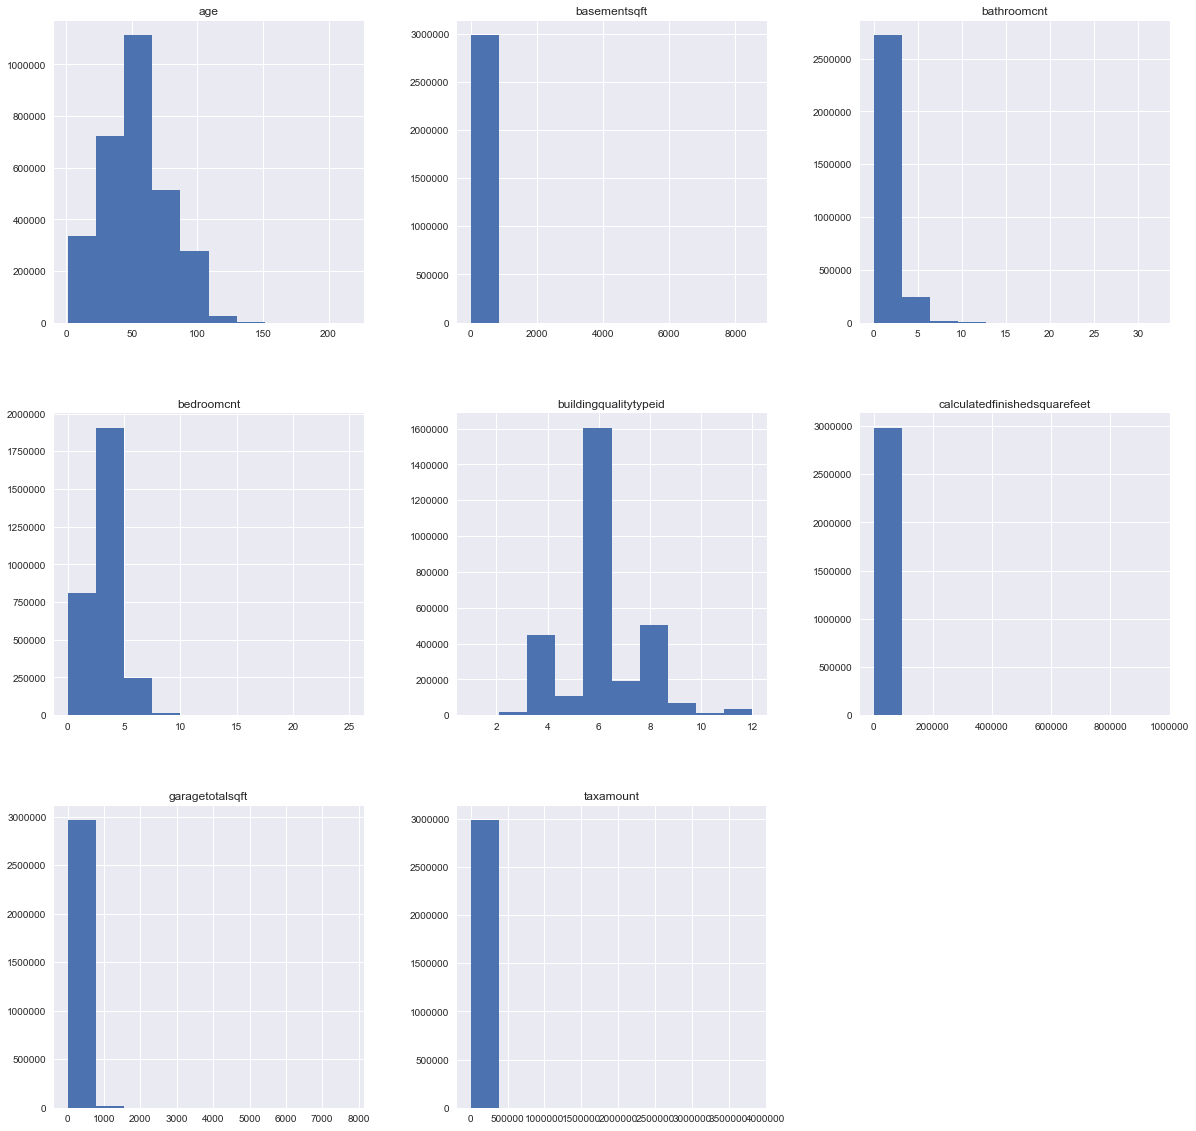

In [7]:
imputed_scoring_features.hist()

Many of our plots seem uninfomative.  Let us try using a log-y plot.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x111c7bed0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11039f490>]], dtype=object)

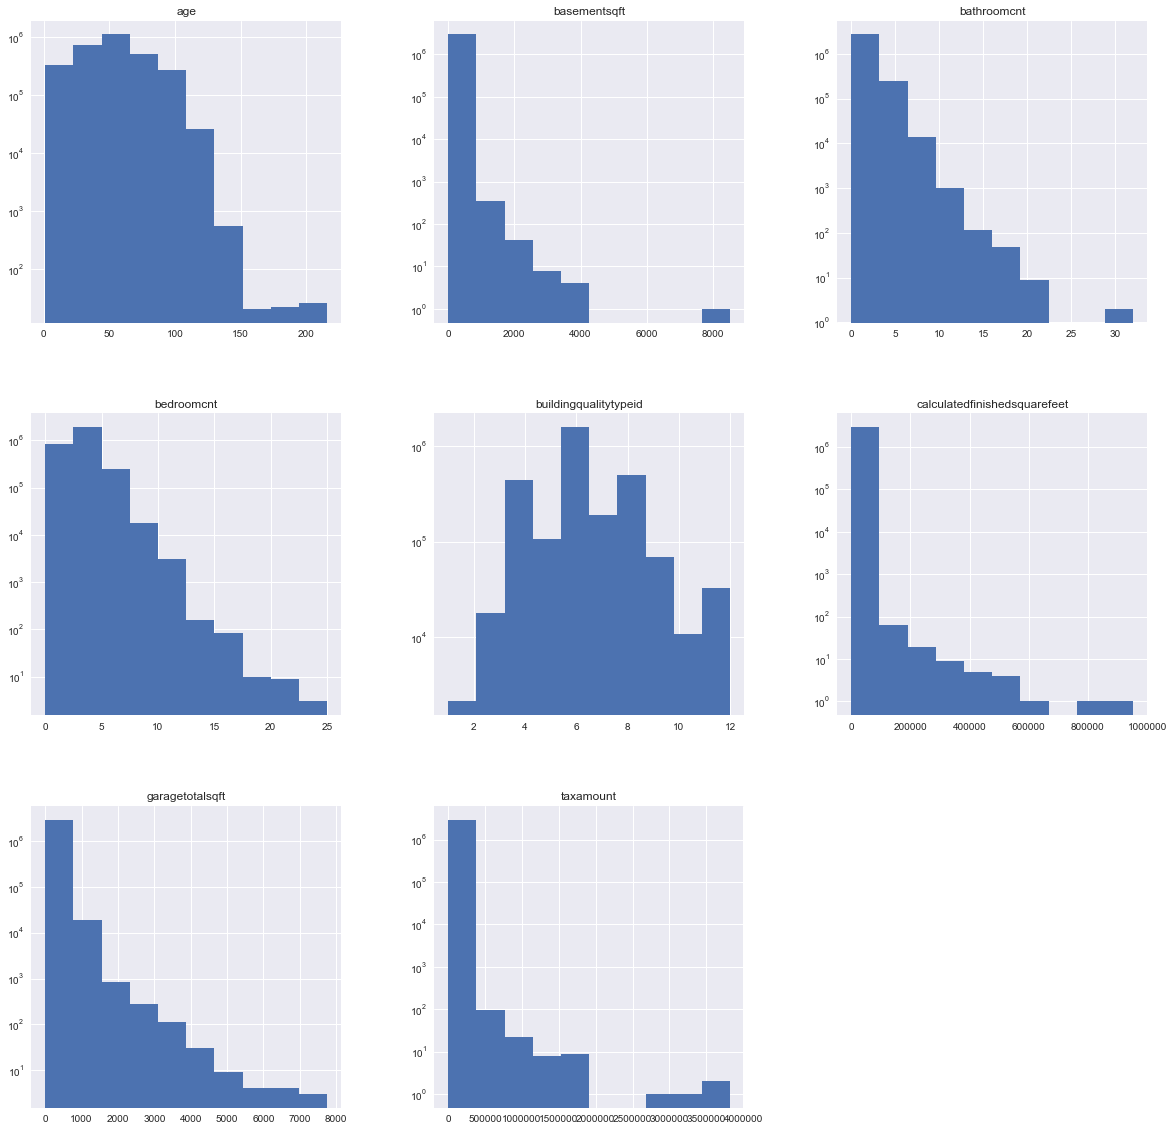

In [8]:
imputed_scoring_features.hist(log=True)

Observing the plots above leads to an observation that some of the features seem to have heavy outliers.  In particular let us apply the log to 'basementsqft', 'calculatedfinishedsquarefeet', 'garagetotalsqft', and 'taxamount'.

In [9]:
imputed_scoring_features[['basementsqft', 'calculatedfinishedsquarefeet', 'garagetotalsqft', 'taxamount']] = imputed_scoring_features[['basementsqft', 'calculatedfinishedsquarefeet', 'garagetotalsqft', 'taxamount']].apply(np.log).replace([np.inf, -np.inf], 0)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x110449710>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1133e6d90>]], dtype=object)

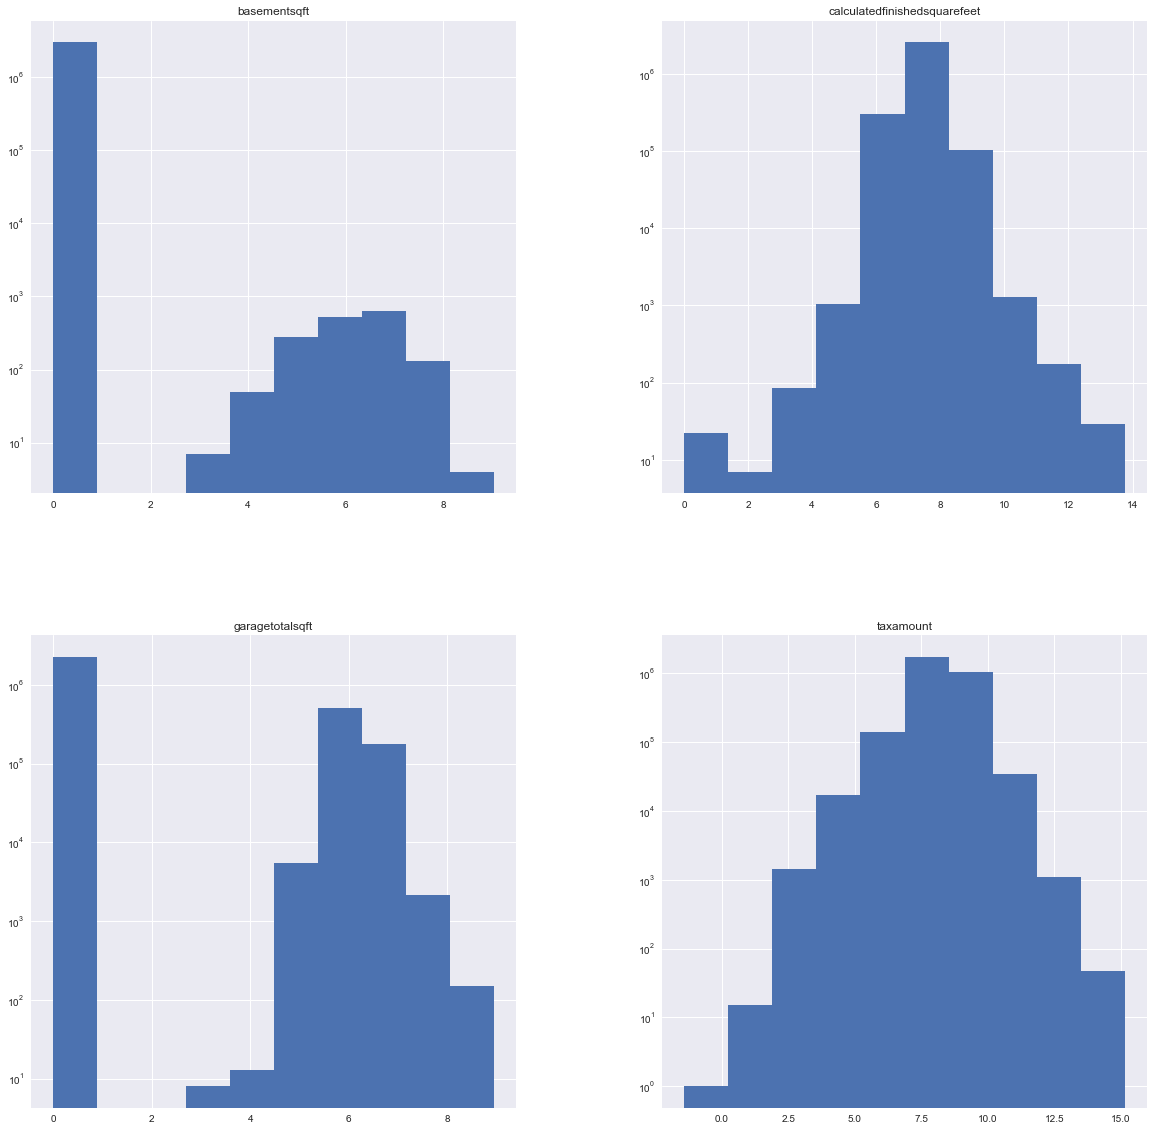

In [10]:
imputed_scoring_features[['basementsqft', 'calculatedfinishedsquarefeet', 'garagetotalsqft', 'taxamount']].hist(log=True)

Plotting the above log-features shows roughly normally distributed values.  'basementsqft' and 'garagetotalsqft' both exhibit bimodal behavior due to the imputation strategy of 0-replacement.

Finally, let us apply z-score normalization to our entire feature matrix.

In [11]:
cleaned_scoring_features = imputed_scoring_features.apply(zscore)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1134b5a10>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1108d9d10>]], dtype=object)

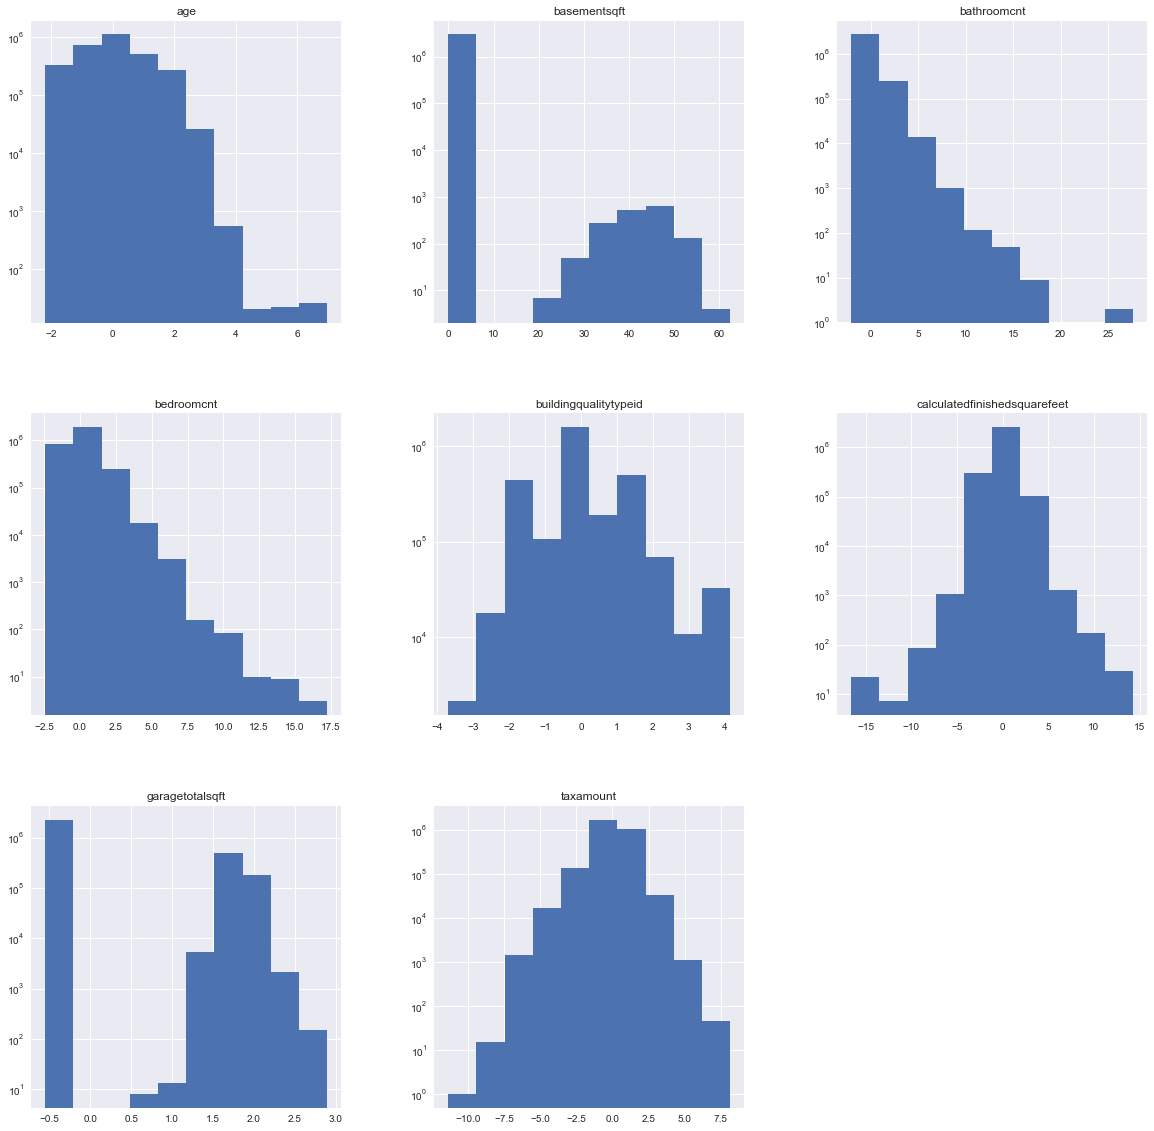

In [12]:
cleaned_scoring_features.hist(log=True)

It seems that most of our features exhibit roughly symmetric normal empirical distributions.  We are now in a position to create a scoring function and rank our dataset.

## Scoring and Ranking

After z-score nomalization some of our data is still not conforming to a standard range.  To alleviate this we will apply the following weighted formulation as our scoring function: 

$- \text{age} + 0.1 \times \text{basementsqft} + 0.2 \times \text{bathroomcnt} + 0.5 \times \text{bedroomcnt} - \text{buildingqualitytypeid} + \text{calculatedfinishedsquarefeet} + 2 \times \text{garagetotalsqft} + \text{taxamount}$

Where we try to constrain the ranges within -10 and 10 and apply positive or negative weightings based on the features contribution to the score.  So for example, taxamount has a positive weighting since it reflects the assessment of value for your house and is generally a strong signal. 

In [13]:
scores = (-1 * cleaned_scoring_features['age']) + (.1 * cleaned_scoring_features['basementsqft']) + (.2 * cleaned_scoring_features['bathroomcnt']) - cleaned_scoring_features['buildingqualitytypeid'] + cleaned_scoring_features['calculatedfinishedsquarefeet'] + (2 * cleaned_scoring_features['garagetotalsqft']) + cleaned_scoring_features['taxamount'] 

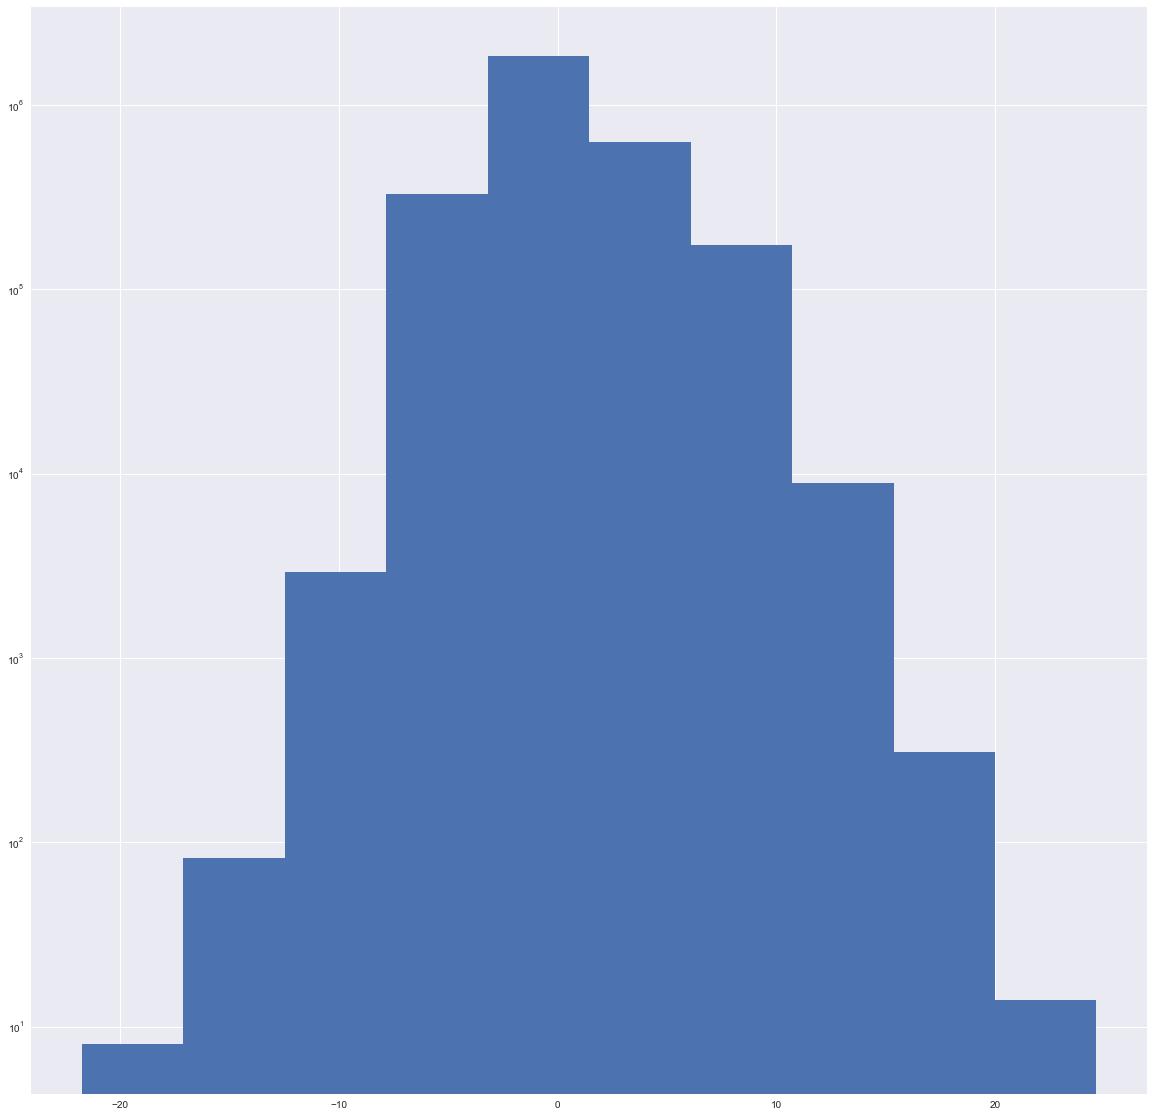

In [14]:
scores.hist(log=True)

We find the ten most desirable houses to have the following scores:

In [15]:
print scores.nlargest(10)
high_keys = scores.nlargest(10).index.values

1520509    24.641774
254641     21.767707
342941     21.646459
1252741    21.406466
1041194    20.772267
432636     20.705109
1938915    20.698654
1133400    20.585368
2849244    20.551440
462377     20.474433
dtype: float64


We find the ten least desirable houses to have the following scores:

In [16]:
print scores.nsmallest(10)
low_keys = scores.nsmallest(10).index.values

1998676   -21.761091
1449989   -20.569205
2795091   -20.125434
80982     -18.850424
1768213   -17.930878
809346    -17.798545
1972644   -17.590825
2268215   -17.143430
1732202   -16.754876
2336074   -16.646185
dtype: float64


Using the fact that the indices were never permuted in our subsampling and cleaning, we can match row IDs to find the parcelid of the best residences.

In [17]:
print X['parcelid'][high_keys]

1520509    17291058
254641     17284931
342941     11746970
1252741    11984395
1041194    14324358
432636     11525376
1938915    11467277
1133400    10806423
2849244    17284897
462377     12560578
Name: parcelid, dtype: int64


The least desirable houses are as follows:

In [18]:
print X['parcelid'][low_keys]

1998676    12546681
1449989    11243663
2795091    12201284
80982      12186499
1768213    12586087
809346     11504997
1972644    11490532
2268215    10740889
1732202    10887059
2336074    12995195
Name: parcelid, dtype: int64


As a sanity check, let's print the imputed feature values for the best and worst houses.

Most desirable houses:

In [19]:
print original_scoring_features.iloc[high_keys]

         bathroomcnt  bedroomcnt  calculatedfinishedsquarefeet   taxamount  \
1520509          9.5         6.0                       18117.0   283062.46   
254641           8.5         4.0                       12451.0    56903.60   
342941           0.0         0.0                      520825.0  3458861.12   
1252741          0.0         0.0                      472363.0  3277055.20   
1041194         14.5         9.0                       27100.0   179778.36   
432636           0.0         0.0                      512019.0  1548030.07   
1938915          0.0         0.0                      522511.0  1840935.06   
1133400          0.0         0.0                      454102.0  1757913.92   
2849244          9.0         4.0                       14003.0    86888.14   
462377           0.0         0.0                      617114.0  1030259.32   

         basementsqft  garagetotalsqft  buildingqualitytypeid   age  
1520509        8516.0           4000.0                    6.0  25.0  
2

Here we see that the most desirable houses indeed seem pretty desirable having large finished area, spacious basements and garages, and many bedrooms.  There are some properties which do not seem to be living areas per se, but are very large and have astronomical tax rates.

Least desirable houses:

In [20]:
print original_scoring_features.iloc[low_keys]

         bathroomcnt  bedroomcnt  calculatedfinishedsquarefeet  taxamount  \
1998676          0.0         1.0                           1.0     705.24   
1449989          0.0         0.0                           1.0     439.55   
2795091          1.0         3.0                           1.0     870.36   
80982            1.0         2.0                           1.0    1996.35   
1768213          3.0         1.0                           1.0    2020.66   
809346           2.0         5.0                           3.0    1676.86   
1972644          2.0         3.0                           1.0    4141.46   
2268215          2.0         3.0                           2.0    1134.93   
1732202          2.0         2.0                           7.0     650.99   
2336074          2.0         3.0                           2.0    2774.43   

         basementsqft  garagetotalsqft  buildingqualitytypeid    age  
1998676           0.0              0.0                    6.0   95.0  
1449989   

The very worst houses seem terrible with high taxes and almost no finished square feetage.  Additionally, these houses are very old.  However, it is quite possible that the 'calculatedfinishedsquarefeet' for these houses are input errors or due to some technicality.  It is also possible that these are historical properties given their age.

## Report

A key insight which we learned from designing the scoring function is that a simple heuristic statistic can capture real world phenomena quite accurately.  Many of the features present in the housing dataset are extraneous but may be used by Zillow to get a .0001 edge over the competition.  However, these features do not really add much to what an actual person would consciously consider when comparing properties.  

We chose to model the desirability of a house by what real people would consider: size, amenities, and age.  We also used the tax evaluation of the property, since this represents a strong signal as to what the property is really worth.  It could be argued that the tax evaluation would have served better as a proxy to test our function with.  However, it is our belief that by incorporating this important information our scoring function better captures "desirability".

It is true that location plays a large role in the desirability of a home.  However, there is no simple way to order all of the possible locations to make a quantitative statement about the contribution to a home's worth.  A way to incorporate such knowledge would require an entirely separate analysis of locations in Los Angeles and their relative rankings.  Since this seems to be a bit beyond the scope of this assignment, we chose to defer using locational data until comparisons can be made directly (using the key identifiers) in the distance function.

Although there is certainly room for improvement, our simple scoring function has withstood the sniff test.  It seems to really find some difference in the desirability of the properties that translates into a real world interpretation.  The best houses are spacious, with many bedrooms and other such luxeries.  The worst houses (according to the data) have a very low amount of finished square feetage and are also old with low tax evaluation.  It should be noted that many of the top tier houses may not be houses at all, which is reflected by their large finished area and high tax evaluation, but lack of bedrooms, bathrooms, etc.

While a ranking/scoring gives some insight into the data, we believe that there is another fundamental merit of this process.  To create a reasonable scoring function, one must take the time to consider the domain carefully.  It is through this process of consideration and data exploration that we can really begin to understand which variables really define our dataset.  This seems to be a very good general idea: slow down and consider the data before throwing it into a slew of machine learning algorithms.

# Distance Function

## Feature Selection

### Using the Scoring Function

To define our distance function we will take advantage of much of the heavy lifting we have already done and use the output of our scoring function as one feature for our distance measure.

In [21]:
print scores.nlargest(1).iloc[0] - scores.nsmallest(1).iloc[0]

46.402864407


We see that the difference potential between the largest and smallest scores is quite large.  We will need to normalize these values to be within $[0, 1]$.

In [22]:
z = scores.nlargest(1).iloc[0] - scores.nsmallest(1).iloc[0]  # Normalization constant

Let's test a few values to make sure that this works how we expect...

In [23]:
for x in range(0, 10):
    print abs(scores.sample(1).iloc[0] - scores.sample(1).iloc[0]) / z

0.0159989665486
0.143134423106
0.126381121202
0.162993494113
0.0487229886827
0.0593903161531
0.116362300519
0.081584755069
0.0355401963882
0.0400172981823


Our values seem to be in the correct range, with most scored differences being relatively small.  To incorporate this function using builtin $l_2$ norm implementations we will normalize to $[0, 1]$.

In [24]:
scores = (scores - scores.nsmallest(1).iloc[0]) / z

### Incorporating Geography

To use geographic information we will take advantage of the longitude and latitude features in the dataset.

In [25]:
locations = X[['longitude', 'latitude']]

In [26]:
print locations.head()

     longitude    latitude
0 -118654084.0  34144442.0
1 -118625364.0  34140430.0
2 -118394633.0  33989359.0
3 -118437206.0  34148863.0
4 -118385816.0  34194168.0


Let us determine the percentages of missing data per location feature.

In [27]:
print 'longitude: ' + str(float(locations['longitude'].isnull().sum()) / locations.shape[0] * 100) + '%'
print 'latitude: ' + str(float(locations['latitude'].isnull().sum()) / locations.shape[0] * 100) + '%'

longitude: 0.0982173155251%
latitude: 0.0982173155251%


Next let us determine the range of our data.

In [28]:
print 'Range of longitude: ' + str(locations['longitude'].nlargest(1).iloc[0] - locations['longitude'].nsmallest(1).iloc[0])
print 'Range of latitude: ' + str(locations['latitude'].nlargest(1).iloc[0] - locations['latitude'].nsmallest(1).iloc[0])

Range of longitude: 1921464.0
Range of latitude: 1495262.0


In the context of geographical coordinates mean inputation seems reasonable since there should be little outliers to skew the data.

In [29]:
locations = locations.fillna(locations.mean())

Next let us normalize the longitude and latitude using $[0, 1]$ normalization.

In [30]:
locations['longitude'] = (locations['longitude'] - locations['longitude'].nsmallest(1).iloc[0]) / (locations['longitude'].nlargest(1).iloc[0] - locations['longitude'].nsmallest(1).iloc[0])
locations['latitude'] = (locations['latitude'] - locations['latitude'].nsmallest(1).iloc[0]) / (locations['latitude'].nlargest(1).iloc[0] - locations['latitude'].nsmallest(1).iloc[0])

In [31]:
locations.head()

,longitude,latitude
0,0.427641,0.548435
1,0.442588,0.545752
2,0.562668,0.444719
3,0.540512,0.551392
4,0.567257,0.581691


Finally, let's combine the scoring data with the location data into a new distance feature dataframe.

In [32]:
distance_features = locations[['longitude', 'latitude']].copy()
distance_features['score'] = scores.copy()

## Experiments

Next let us examine how the distances are distributed within a subset of the data.  Having selected which features will contribute to the distance we will utilize the standard Euclidean distance functio as our metric.

In [33]:
sample_size = 10000
subsample = distance_features.sample(sample_size)
distances = euclidean_distances(subsample)

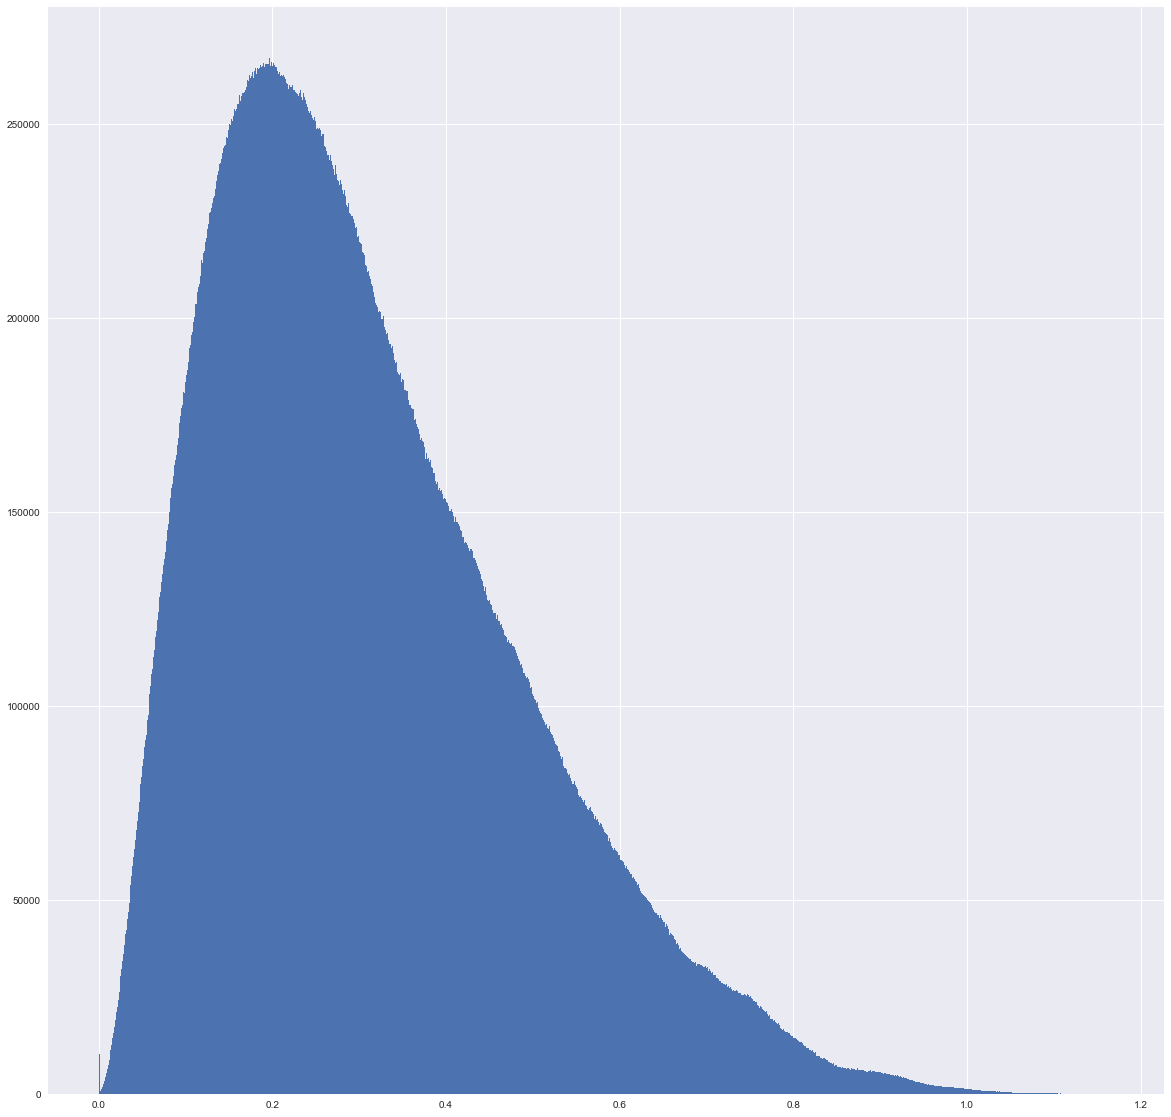

In [43]:
plt.hist(np.hstack(distances), bins='auto')
plt.show()

We observe a nice distribution of distances with most properties being different in some manner as expected of real data.

## Report

The process of determining good features for a distance metric is somewhat similar to that of choosing corresponding features for a scoring method.  In both cases one needs to critically evaluate the features in the data which contribute to the "definition" of being a representative object.  As we mentioned earlier, this process ultimately will lead to a stronger understanding of the problem space and hopefully lead to better models.

While there are many similarities in feature selection between scoring and distance, there is a clear difference in the interpretation of the numerical output we achieve.  Given the fact that our eventual goal is to cluter the dataset using our distance function, we needed to constrain the range of values that a feature can contribute.

To achieve this normalization we observed that dividing each score by the range lead to desirable results.  After normalization the score difference was constrained to be $1$ only when the best and worst properties were compared, and positive $\lt 1$ otherwise.  We also needed to constrain the geographical feature range, since the original representation was in the tens to hundreds of millions.  Our approach to normalizing the geographical data was byb using mean imputation and $[0, 1]$ normalization.  We thought that mean imputation was a reasonable approach given the nature of the geographical data.

Having cleaned and normalized our data we then experimented via random subsampling of the data matrix $X$.  We used the Euclidean distance metric as our distance function as our clustering algorithm of choice is k-means.  The theoretical properties of k-means require that Euclidean distance is used for proper convergence.  As shown above, we found that the empirical distribution of distances was very satisfactory.  Most properties were dissimilar, with ranges smoothly transitioning between those which were more dissimilar than others.

Prior to testing our distance function with clustering we had many failed iterations.  In the first case we tried using regionid based locations and creating a custom distance function by boolean comparison.  However, this approach did not work since efficient clustering implementations required a directly comparable Euclidean computation.  After choosing longitude and latitude as our geographical features, we also met failure by improperly normalizing our data using z-scores.  The z-score normalization lead to imbalanced distance features where the geographical attributes dominated the clusters.  Thus we had partitioned the data into regions, which is not entirely interesting as we wish to also observe "desirability" scores as well.

# Clustering

For our clustering analysis we will impose our cluster classes onto the scatter plot of longitude and latitude.

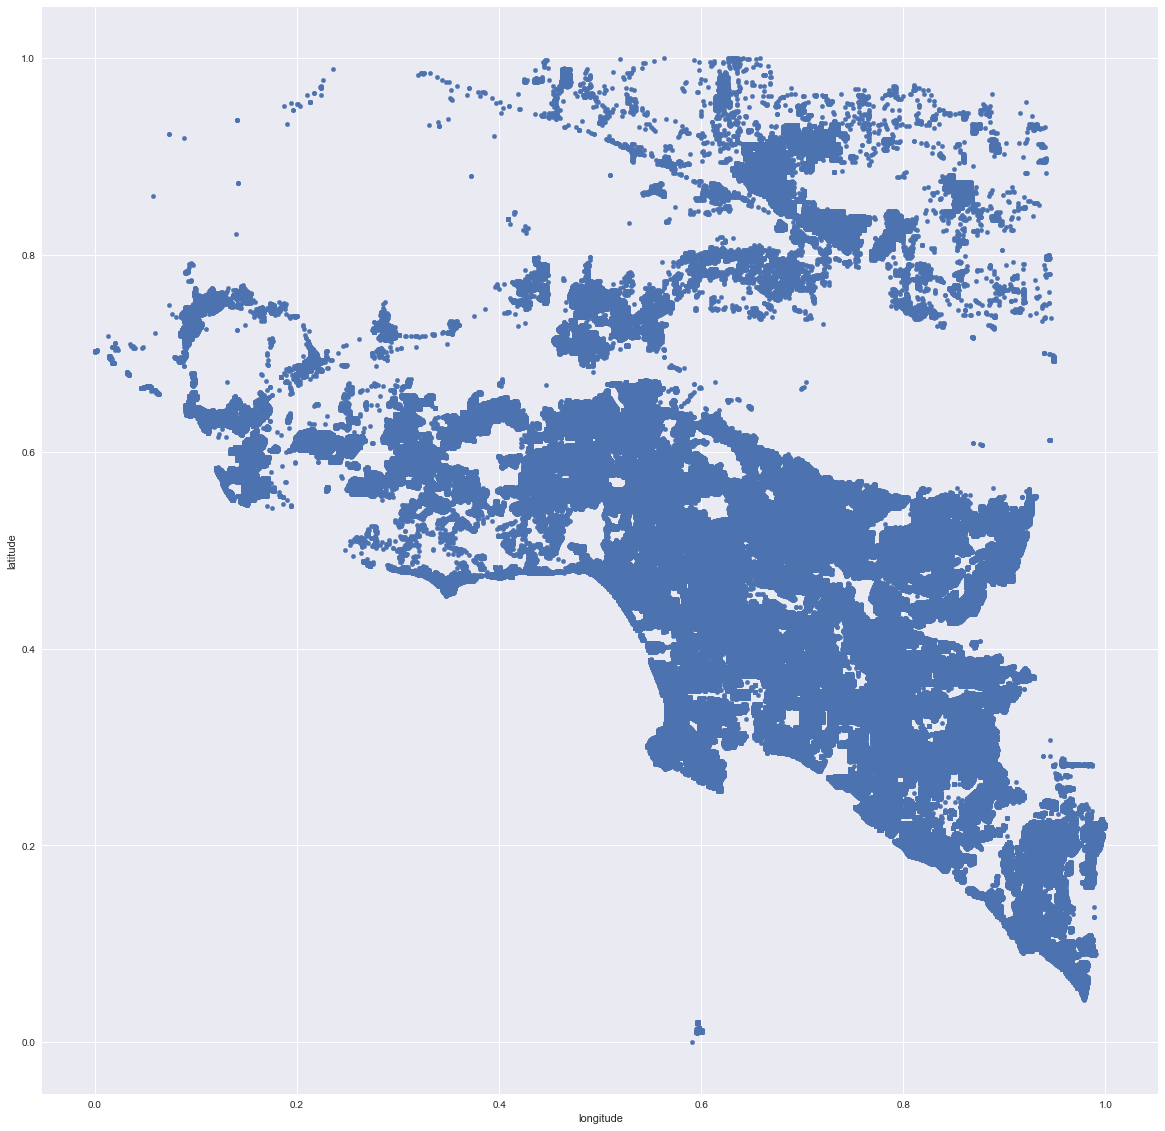

In [35]:
locations.plot(kind='scatter', x='longitude', y='latitude')

## Experiments

### k = 10

In [36]:
km = sklearn.cluster.KMeans(n_clusters=10)
km.fit(distance_features.as_matrix())
labels = km.labels_

In [37]:
results = pd.DataFrame(data=labels, columns=['cluster'], index=distance_features.index)

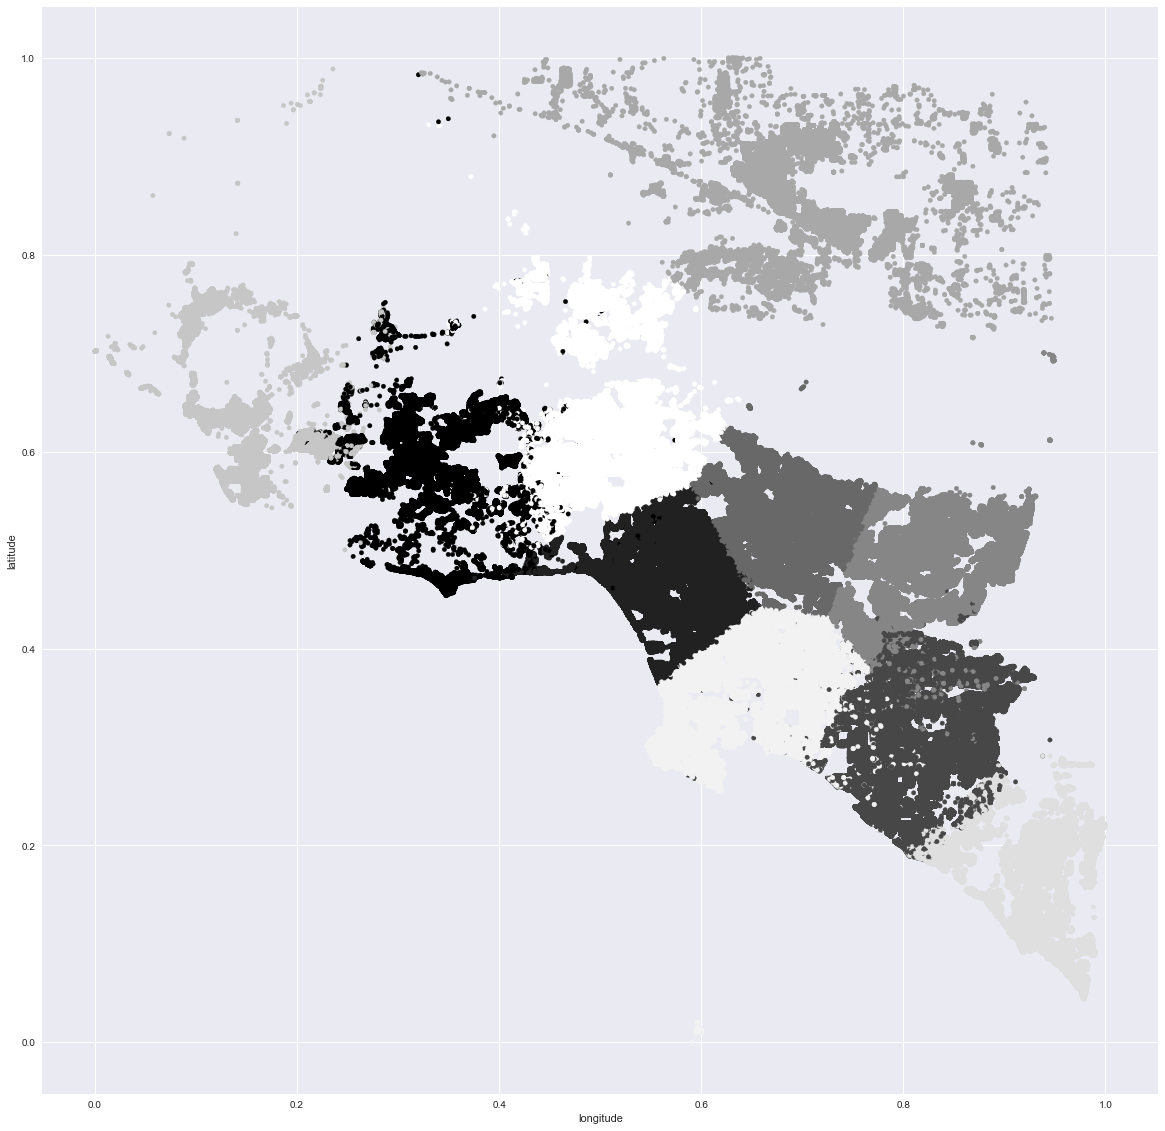

In [38]:
locations.plot(kind='scatter', x='longitude', y='latitude', c=results['cluster'])

It seems that $k=10$ is a little too coarse of a clustering and mostly clusters by geographic location.

### k = 25

In [44]:
km = sklearn.cluster.KMeans(n_clusters=25)
km.fit(distance_features.as_matrix())
labels = km.labels_

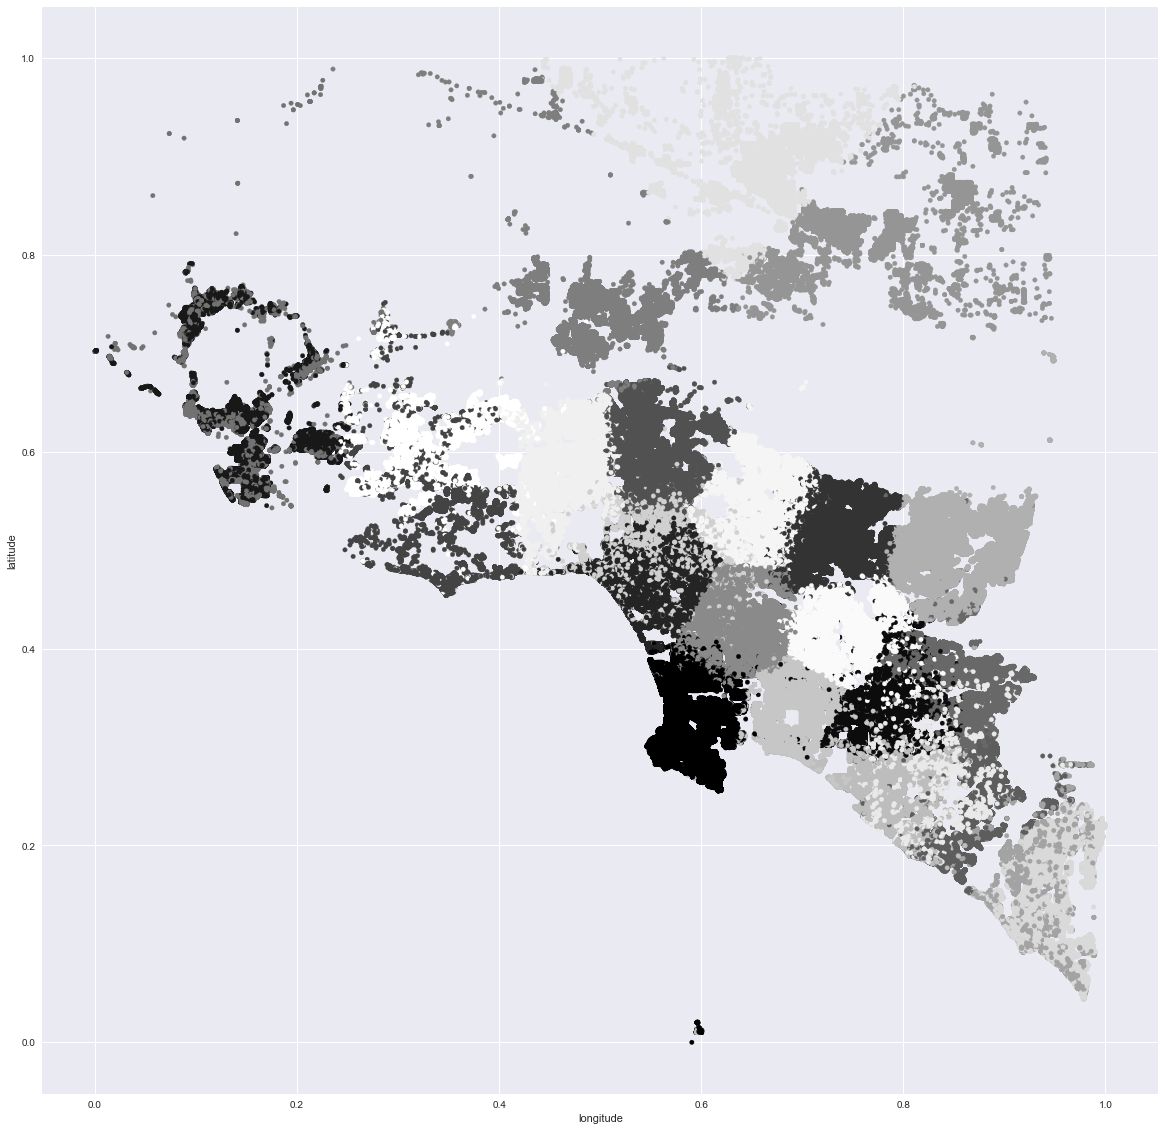

In [45]:
results = pd.DataFrame(data=labels, columns=['cluster'], index=distance_features.index)
locations.plot(kind='scatter', x='longitude', y='latitude', c=results['cluster'])

Using $k=25$ we see more clusters formed not only via geography.

## Report

To achieve clusters of our data we used the k-means algorithm.  Due to our choice of distance features we see that our clustering results reflect both geographical data as well as our scoring function.  We can see that our scoring function has a role in the results by examining the "pollution" between clusters which would otherwise make for fine geographical lines.  The effect of our scoring function is muted in the case of $k=10$ however one may still see the mixing phenomena which represents that some properties are more similar to other properties in a farther geographic region than the surrounding space.

We were not entirely pleased with the results of $k=10$ however.  The cluster centroids seemed to be heavily influenced by geographical proximity rather than "desirability".  Thus we tried the parameter of $k=25$ to try and gain more definition.  The logic is that if there are more clusters the geographical proximity measure must be dilluted in such a way that the total area of any single cluster would be reduced.  Indeed by examining our result for $k=25$ we see that many geographical regions have multiple cluster mixtures.  This implies that many of the houses can be partitioned via our "desirability" scores.

It is a good grounding check that geographical region does play a large role in the clustering.  This should be the case as our distance metric is more heavily weighted towards geography ($2/3$ of the features are geographical).  The different mixtures in the $k=25$ case shows that there is a real difference in the size, tax evaluation, and etc between a single contiguous area.  This distinction was not represented in the $k=10$ test.

We decided to stop at $k=25$ since any futher increase in cluster size would make the data less interpretable.  We have already teased out regions in space which are of interest and noted real world correspondences in the data to our intuition.

# External Dataset Integration

# Improved Model

# Permutation Test